[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Erinin_et_al_2025/expansion_experiment.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Erinin_et_al_2025/expansion_experiment.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Erinin_et_al_2025/expansion_experiment.ipynb)

modeling expansion-chamber experiments with empty chamber (~zero seed particles)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM import products as PySDM_products
from PySDM_examples.Erinin_et_al_2025.aerosol import AerosolChamber
from PySDM_examples.Erinin_et_al_2025.expansion_simulation import run_expansion

In [3]:
dry_radius_bin_edges = np.geomspace(50 * si.nm, 2000 * si.nm, 40, endpoint=False)
wet_radius_bin_edges = np.geomspace(1 * si.um, 40 * si.um, 40, endpoint=False)

products = (
    PySDM_products.SuperDropletCountPerGridbox(name="SD count"),
    PySDM_products.WaterMixingRatio(unit="g/kg", name=r"$q_\ell$"),
    PySDM_products.PeakSaturation(name="Saturation ratio"),
    PySDM_products.AmbientRelativeHumidity(name="RH"),
    PySDM_products.AmbientTemperature(name="Temperature", var="T"),
    PySDM_products.AmbientPressure(name="Pressure", var="p", unit="hPa"),
    PySDM_products.AmbientWaterVapourMixingRatio(
        unit="g/kg", name="$q_v$", var="water_vapour_mixing_ratio"
    ),
    PySDM_products.Time(name="t"),
    PySDM_products.ParticleSizeSpectrumPerVolume(
        name="dry:dN/dR",
        unit="m^-3 m^-1",
        radius_bins_edges=dry_radius_bin_edges,
        dry=True,
    ),
    PySDM_products.ParticleSizeSpectrumPerVolume(
        name="wet:dN/dR",
        unit="m^-3 m^-1",
        radius_bins_edges=wet_radius_bin_edges,
        dry=False,
    ),
    PySDM_products.ActivatedEffectiveRadius(
        name="act_reff", unit="um", count_activated=True, count_unactivated=False
    ),
    PySDM_products.EffectiveRadius(
        name="$r_{eff}$",
        unit="um",
    ),
    PySDM_products.ParticleConcentration(
        name="$N_d$",
        unit="cm^-3",
        # radius_range=(0.5 * si.um, 25 * si.um),
    ),
) 

In [14]:
FORMULAE = Formulae(
    adiabatic_exponent="MoistLeadingTerms",
    homogeneous_liquid_nucleation_rate='CNT',
)
CONST = FORMULAE.constants

N_SD_PER_MODE = 20
DT = .01 * si.s

C0 = 1 / si.cm**3
P0 = 1000 * si.hPa
PF_arr = np.linspace(620,680,4)*si.hPa
DELTA_TIME = 0.5*si.s

In [19]:
output_all = {}

aerosol = AerosolChamber(
        water_molar_volume=CONST.Mv / CONST.rho_w,
        N=C0,
    )

for PFi in PF_arr:
    key = f"pf={PFi:.2e}"
    print(key)
    
    output = run_expansion(
        formulae=FORMULAE,
        aerosol=aerosol,
        n_sd_per_mode=N_SD_PER_MODE,
        n_sd_homo_liq_nucleation=1000,
        p0=P0,
        pf=PFi,
        delta_time=DELTA_TIME,
        total_time=5*si.s,
        dt=DT,
        products=products,
    )

    output_all[key] = output


pf=6.20e+04
pf=6.30e+04
pf=6.40e+04
pf=6.50e+04
pf=6.60e+04
pf=6.70e+04
pf=6.80e+04


130898688.89495
7358438.967978572
295163.2019142857
8023.87325
138.96157857142856
1.4229142857142858
0.007721428571428572


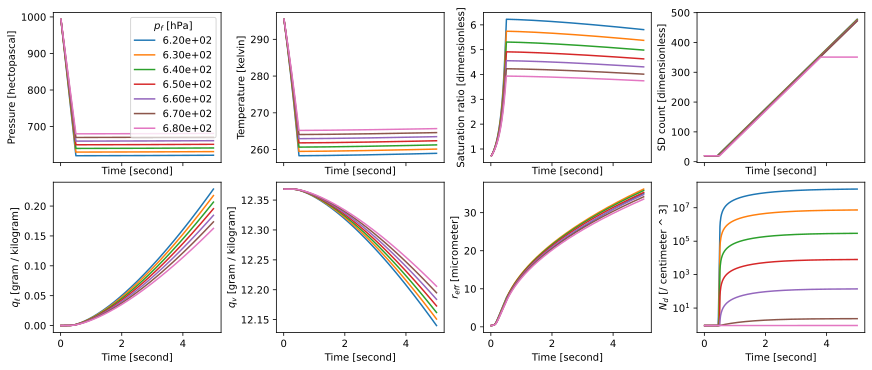

HTML(value="<a href='./PF_sweep_traces.pdf' target='_blank'>./PF_sweep_traces.pdf</a><br>")

In [20]:
variables = ["Pressure", "Temperature", "Saturation ratio", "SD count", r"$q_\ell$", "$q_v$", "$r_{eff}$", "$N_d$"]
fig, axes = pyplot.subplots(2,4,figsize=(12,5), sharex=True, sharey=False, constrained_layout=True)

for PFi in PF_arr:
    key = f"pf={PFi:.2e}"
    output = output_all[key]
    init_mult = output.attributes["multiplicity"][0]
    final_mult = output.attributes["multiplicity"][-1]
    print((np.sum(final_mult) - np.sum(init_mult)) / np.sum(init_mult))
    for i, ax in enumerate(axes.flatten()):
        y = np.array(output.profile[variables[i]])
        ax.plot(output.profile["t"], y, label=f"{in_unit(PFi, si.hPa):.2e}")
        if i == 7:
            ax.set_yscale("log")
            # ax.set_ylim(3e2,8e2)
        ax.set_xlabel(f"Time [{output.units['t']}]")
        ax.set_ylabel(f"{variables[i]} [{output.units[variables[i]]}]")

axes[0, 0].legend(title="$p_f$ [hPa]")
fig.set_facecolor('white')
show_plot("PF_sweep_traces.pdf")